$\qquad$ $\qquad$$\qquad$  **TDA 231 Machine Learning: Home Assignment 5 -- Clustering** <br />
$\qquad$ $\qquad$$\qquad$ **Goal: K-means, GMM, EM**<br />
$\qquad$ $\qquad$$\qquad$                   **Grader: Yuchong, Divya** <br />
$\qquad$ $\qquad$$\qquad$                     **Due Date: 29th May** <br />
$\qquad$ $\qquad$$\qquad$                   **Submitted by: Adam Olsson, 950418-3170, adaolss@student.chalmers.se and    Gabriel Lindeby, 19951027-1779, gablinde@student.chalmers.se** <br />


---


General guidelines:
*   All solutions to theoretical and pratical problems must be submitted in this ipynb notebook, and equations wherever required, should be formatted using LaTeX math-mode.
*   All discussion regarding practical problems, along with solutions and plots should be specified in this notebook. All plots/results should be visible such that the notebook do not have to be run. But the code in the notebook should reproduce the plots/results if we choose to do so.
*   Your name, personal number and email address should be specified above.
*   All tables and other additional information should be included in this notebook.
*   **All the answers for theoretical questions must be filled in the cells created for you with "Your answer here" below each question, but feel free to add more cells if needed.**
*   Before submitting, make sure that your code can run on another computer. That all plots can show on another computer including all your writing. It is good to check if your code can run here: https://colab.research.google.com.


# Practical problems

The follwing code might be useful for this excercise.

```python
import scipy.io
mat = scipy.io.loadmat('hw5_p1a.mat')
print (mat.keys())
X = mat['X']
```

## [K-Means Implementation, 8 points]

a. Implement the basic (linear) $k$-means algorithm as described in the lecture, using the euclidean distance. Use (uniformly) random points from the data as initialization for the centroids. Terminate the iterative procedure when the the cluster assignments do not change. [**2 pts**]

b. Run your implementation on the matrix $X$ in **hw5_p1a.mat** with $k=2$. Each row of the matrix is an observation, and each column is a feature. Store the cluster assignment both after 2 iterations, and at convergence. Produce a scatter plot of the data with colors indicating the cluster assignments at convergence and highlight points that have changed assignment after the second iteration. [**2 pts**]

c. Implement the kernel $k$-means algorithm as described in the lecture, using the Gaussian RBF-kernel. [**2 pts**]

d. Run the linear $k$-means **and** your kernel $k$-means on **hw5_p1b.mat** with $k=2$. For the Gaussian RBF-kernel, use $\sigma=0.2$. Produce scatter plots of the data, with color indicating the cluster assignment at convergence, one plot for each of the algorithms. [**2 pts**]

### Your answer here:

Centroids settles after 5 iterations.


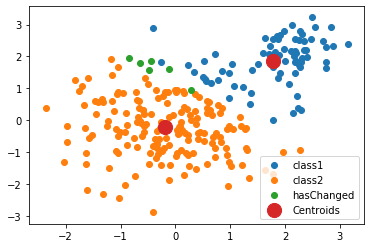

In [48]:
import numpy as np
from numpy.random import uniform
import matplotlib.pyplot as plt

import scipy.io
mat = scipy.io.loadmat('hw5_p1a.mat')
#print (mat.keys())
X = mat['X']

def k_means(X, k=2):
    (n, noFeat) = X.shape
    
    # randomly instantiate mu
    mu = uniform(-5, 5, (k, noFeat))
    
    point_assignment_iter_2 = None
    
    mu_previous = None
    no_iterations = 0
    while not np.array_equal(mu_previous, mu):
    
        mu_previous = np.copy(mu)
            
        # Calculate distances to each centroid
        distances = np.zeros((n,k))
        for centroid in range(k):
            distances[:, centroid] = euclidian_distance(X, mu[centroid,:])
        
        z = np.zeros((n, k))
        
        # assign each point to closest centroid
        z[range(n), np.argmin(distances, axis=1)] = 1


        # Get number of assigned points to each centroid
        no_assigned_points = np.sum(z, axis=0)
    
        # Update center centroids
        for centroid in range(k):
            mu[centroid,:] = np.sum(X*np.expand_dims(z[:,centroid],axis=1), axis=0)/no_assigned_points[centroid]
        
        if no_iterations == 1:
            point_assignment_iter_2 = z
        
        no_iterations += 1
    
    print("Centroids settles after {} iterations.".format(no_iterations))
    
    
    ## Plotting
    has_changed_centroid = (point_assignment_iter_2 != z)[:,0].astype(int)
    
    class1 = []
    class2 = []
    hasChanged = []
    for p in range(n):
        if has_changed_centroid[p]:
            hasChanged.append(X[p,:])
        elif z[p,0] == 1:
            class1.append(X[p,:])
        elif z[p,1] == 1:
            class2.append(X[p,:])
    
    class1 = np.array(class1)
    class2 = np.array(class2)
    hasChanged = np.array(hasChanged)

    
    fig, axes = plt.subplots(nrows=1,ncols=1)
    axes.scatter(class1[:,0], class1[:,1], label='class1')
    axes.scatter(class2[:,0], class2[:,1], label='class2')
    axes.scatter(hasChanged[:,0], hasChanged[:,1], label='hasChanged')
    axes.scatter(mu[:,0], mu[:,1], s=200, label='Centroids')
    axes.legend()
    plt.show()

    
def euclidian_distance(x, y):
    return np.sqrt(np.sum(np.square(x-y), axis=1))


k_means(X)


Convergence after 6 iterations.


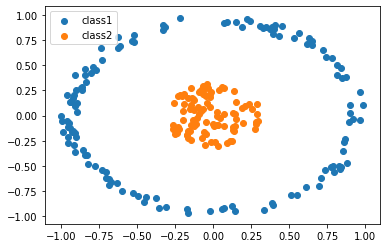

In [64]:
import numpy as np
from numpy.random import randint
import matplotlib.pyplot as plt

import scipy.io
mat = scipy.io.loadmat('hw5_p1b.mat')
#print (mat.keys())
Y = mat['X']

def gaussian_rbf(x,y):
    sigma = 0.2
    L2 = np.linalg.norm((x-y), axis=1)
    return np.array(np.exp(-np.square(L2)/(2*sigma)))

def k_means_kernalized(X, k=2, kernel=gaussian_rbf):
    (n, noFeat) = X.shape
    
    z_new = np.zeros((n,k))
    
    # Randomly assign points to centroids
    for point in z_new:
        point[randint(0,k)] = 1
    
    # While start here
    z = None
    convergence_iter = 0
    while not np.array_equal(z_new, z):
        z = z_new
        N_per_class = np.sum(z, axis=0)

        # Calculate term3 (last term in distance calculation)
        term3 = np.zeros(k)
        for m in range(n):
            t31 = z[m,:]*z
            t32 = kernel(X[m,:], X)
            term3 += np.sum(t31*np.expand_dims(t32, axis=1), axis=0)
        term3 /= np.square(N_per_class)

        z_new = np.zeros((n,k))
        for i, p in enumerate(X):
            # Calculate distances to each centroid
            t11 = np.expand_dims(p, axis=0)
            term1 = kernel(t11,t11)

            t21 = kernel(np.expand_dims(p, axis=0), X)
            t22 = np.sum(z*np.expand_dims(t21, axis=1), axis=0)
            term2 = t22*2/N_per_class

            distances = term1 - term2 + term3

            # Determine the closes one and assign the point
            z_new[i, np.argmin(distances)] = 1
        convergence_iter += 1
    
    print("Convergence after {} iterations.".format(convergence_iter))
    
    # Plotting
    class1 = X[z_new[:,0] == 1]
    class2 = X[z_new[:,1] == 1]
    
    fig, axes = plt.subplots(nrows=1,ncols=1)
    axes.scatter(class1[:,0], class1[:,1], label='class1')
    axes.scatter(class2[:,0], class2[:,1], label='class2')
    axes.legend()
    plt.show()
    

k_means_kernalized(Y)

# GMM [4 pts]

We will now consider mixture model. The probability of an observation $x \in \mathbb{R}^D$ is given by: $$p(x) = \sum_{k=1}^{K} \pi_k P(x|\theta_k)$$ where $\pi_k$ are the probabilities a priori and $P(x|\theta_k)$ are multi-dimensional Gaussian characterized by their mean $\mu_k$ and their co-variance matrix $\Sigma_k$
, i.e. $\theta_k = (\mu_k, \Sigma_k)$.

### Q 2.1.
Plot the probability distribution $p(x)$ for D=1 , K = 2, $\pi_1 = \pi_2 = 0.5$ and $\mu_1 = 1$, $\mu_2 = 3$,$\Sigma_1 = 1$,$ \Sigma_2 = 10$. **[2 pts]**

### Q 2.2.

What is the posterior probability that an example $x=1.5$ was produced by the Gaussian $k=1$,i.e. $P(\theta_1| x)$ ? **[2 pts]**

### Your answer here:

### Q 2.1

$$p(x| \mu_{1} = 1, \Sigma_{1}=1) = \frac{1}{2\pi^{\frac{1}{2}} | 1 |^{\frac{1}{2}}}e^{-\frac{1}{2}(x-1)^T inv(1)(x-1)}$$
$$p(x| \mu_{2} = 3, \Sigma_{2}=10) = \frac{1}{2\pi^{\frac{1}{2}} | 10 |^{\frac{1}{2}}}e^{-\frac{1}{2}(x-10)^T inv(10)(x-10)}$$

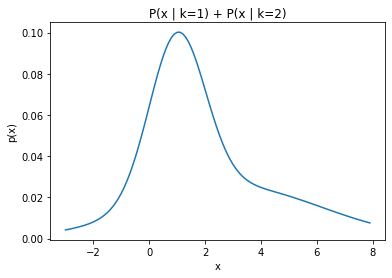

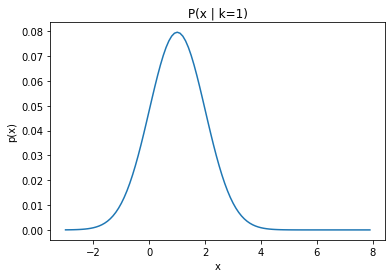

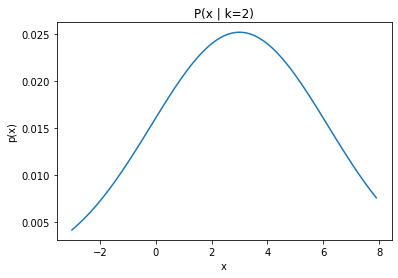

In [122]:
import matplotlib.pyplot as plt
import numpy as np

def P(x, mu, sigma, D=1):
    t1 = 1/( np.power((2*3.1415), D)* np.sqrt(np.linalg.det(sigma)))
    t2 = np.exp(-1/2 * np.transpose(x - mu)*np.linalg.inv(sigma)*(x - mu))
    return t1*t2

pi1 = pi2 = 0.5
mu1 = np.array([[1]])
sigma1 = np.array([[1]])
mu2 = np.array([[3]])
sigma2 = np.array([[10]])

data = []
data_k1 = []
data_k2 = []
x = np.arange(-3,8,0.1)
for p in x:
    p1 = pi1*P(p, mu1, sigma1)
    p2 = pi2*P(p, mu2, sigma2)
    data_k1.append(p1)
    data_k2.append(p2)
    data.append(np.sum(p1 + p2))

data_k1 = np.array(data_k1).flatten()
data_k2 = np.array(data_k2).flatten()


fig1 = plt.figure()
fig2 = plt.figure()
fig3 = plt.figure()
ax1 = fig1.add_subplot(111)
ax2 = fig2.add_subplot(111)
ax3 = fig3.add_subplot(111)

ax1.set_xlabel('x')
ax2.set_xlabel('x')
ax3.set_xlabel('x')

ax1.set_ylabel('p(x)')
ax2.set_ylabel('p(x)')
ax3.set_ylabel('p(x)')

ax1.title.set_text('P(x | k=1) + P(x | k=2)')
ax2.title.set_text('P(x | k=1)')
ax3.title.set_text('P(x | k=2)')


ax1.plot(x, data)
ax2.plot(x, data_k1)
ax3.plot(x, data_k2)

plt.show()

### Q 2.2

$$ p(\theta_{1}| x) = \frac{p(\theta_{1})p(x | \theta_{1})}{p(\theta_{1})p(x | \theta_{1}) + p(\theta_{2})p(x | \theta_{2})} = \frac{\pi_{1}p(x | \theta_{1})}{\pi_{1}p(x | \theta_{1}) + \pi_{2}p(x | \theta_{2})}$$

In [127]:
x = np.array([1.5])
p1 = P(x, mu1, sigma1).flatten()
p2 = P(x, mu2, sigma2).flatten()

answer = pi1*p1 / (pi1*p1 + pi2*p2)

print(answer)

[0.75745788]


# EM algorithm for GMM [8 pts]

Assume that the property prices of Gotheburg follow a mixture of 2 Gaussians, of respective parameters $(\mu_1, \sigma_1^2)$ and $(\mu_2, \sigma_2^2)$.

The table below lists the prices in million SEK of some real estate transactions:
$$\begin{array}{|c|c|c|c|}
\hline
8& 1 & 4 & 3 & 4 & 5 & 7 & 5 & 3 & 5 \\ \hline
\end{array}$$

We will call $\pi_1$ and $\pi_2$ the coefficients of the two Gaussians in the mixture.

### Q 3.1.

Sort the items of the sample in ascending order and use the 5 smallest values for
estimate by maximum likelihood $(\mu_1, \sigma_1^2)$ and 5 larger ones to estimate $(\mu_2, \sigma_2^2)$. Under these conditions, what values should logically be assigned to the weights $\pi_1$ and $\pi_2$? **[2 pts]**

### Q 3.2.

Starting from $\theta^0 = \{\mu_1, \sigma^2_1, \pi_1, \mu_2, \sigma^2_2, \pi_2\}$ obtained from the previous question, estimate the value of responsibilities $\gamma(z_{nk})$ according to the EM algorithm. **[3 pts]**

### Q 3.3.
Re-estimate the parameters i.e. calculate $\theta^1$, using the current responsibilities.**[3 pts]**

### Your answer here:

### Q 3.1

In [247]:
data = np.sort(np.array([8,1,4,3,4,5,7,5,3,5]))

data1 = data[0:int(len(data)/2)]
data2 = data[int(len(data)/2):]

# Mu according to MLE
def mean(data):
    return sum(data)/len(data)

# Variance according to MLE
def variance(data, mu):
    return np.sum(np.square(data-mu))/len(data)

mu1 = mean(data1)
mu2 = mean(data2)

var1 = np.array(variance(data1, mu1))
var2 = np.array(variance(data2, mu2))

print('Data: {}'.format(data.T))
print('First distribition: ({}, {}) \nSecond distribution: ({}, {})'.format(mu1, var1, mu2, var2))

Data: [1 3 3 4 4 5 5 5 7 8]
First distribition: (3.0, 1.2) 
Second distribution: (6.0, 1.6)


$\pi_{1} = \pi_{2} = 0.5$ since an equal amount of points are drawn from both distributions.

### Q 3.2

In [248]:
pi1 = pi2 = 0.5

gamma_k1 = []
gamma_k2 = []
for p in data:
    p1 = pi1*P(p, mu1, sigma1)
    p2 = pi2*P(p, mu2, sigma2)
    gamma_k1.append(p1/np.sum(p1 + p2))
    gamma_k2.append(p2/np.sum(p1 + p2))
    
gamma_k1 = np.array(gamma_k1).flatten()
gamma_k2 = np.array(gamma_k2).flatten()

np.set_printoptions(precision=5, suppress=True)
print('Gamma for k=1: \n{}'.format(gamma_k1))
print('Gamma for k=2: \n{}'.format(gamma_k2))

Gamma for k=1: 
[0.599   0.8322  0.8322  0.70084 0.70084 0.3103  0.3103  0.3103  0.00111
 0.00001]
Gamma for k=2: 
[0.401   0.1678  0.1678  0.29916 0.29916 0.6897  0.6897  0.6897  0.99889
 0.99999]


### Q 3.3

In [249]:

# Book and presentation has different formulas
def update_mu(gamma, x):
    return np.sum(gamma*x)/np.sum(gamma)

def update_variance(gamma, x, mu):
    top = 0
    bottom = 0
    for n in range(len(x)):
        bottom += gamma[n]
        top += gamma[n]*np.square((x[n]-mu))
    return top/bottom

print('Data : {}'.format(data.T))
mu_k1 = update_mu(gamma_k1, data)
var_k1 = update_variance(gamma_k1, data, mu_k1)

mu_k2 = update_mu(gamma_k2, data)
var_k2 = update_variance(gamma_k2, data, mu_k2)

print('Theta0 = [({},{}), ({},{})]'.format(mu1, var1, mu2, var2))
print('Theta1 = [({:.2f},{:.2f}), ({:.2f},{:.2f})]'.format(mu_k1, var_k1, mu_k2, var_k2))

Data : [1 3 3 4 4 5 5 5 7 8]
Theta0 = [(3.0,1.2), (6.0,1.6)]
Theta1 = [(3.45,1.44), (5.39,3.80)]
